# 02. Neural Network Classification with PyTorch


## 1. Make classification data 

In [1]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt 
import torch

In [2]:
# Make 100 samples 
n_samples = 1000

# Create circles 
X, y = make_circles(n_samples,
                        noise=0.03,
                        random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
# We have R² -> R¹
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# Make dataframe with pandas
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circles.head() 

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


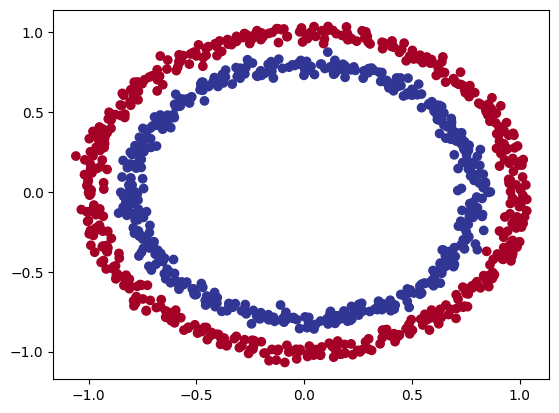

In [6]:
# Visualize 
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.show()

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape # NumPy arrays

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels 
X_sample = X[0]
y_sample = y[0]
print(f"Print values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} anad the same for y: {y_sample.shape}")

Print values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) anad the same for y: ()


### 1.2 Turn data into tensors 

In [9]:
# Torch version
torch.__version__

# Agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Turn data into tensors 
if not torch.is_tensor(X):
    X = torch.from_numpy(X).type(dtype=torch.float)
    y = torch.from_numpy(y).unsqueeze(dim=1).type(dtype=torch.float)

# Check
type(X), type(y), X.shape, y.shape, X.dtype, y.dtype 

/home/jvier/PyTorch-Course/pytorch.env/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


(torch.Tensor,
 torch.Tensor,
 torch.Size([1000, 2]),
 torch.Size([1000, 1]),
 torch.float32,
 torch.float32)

In [10]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    shuffle=True)

In [11]:
len(X_train), len(X_test), n_samples

(800, 200, 1000)

## 2. Building a model 

Obj: Classify our blue and red dots 

1. Setup device agnostic code (alredy done)
2. Construct model (by subclassing `nn.Module`)
3. Define optimizer and loss
4. Construct the training loop 

In [12]:
# Send data to GPU
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device),y_test.to(device)
X_train.device, X_test.device, y_train.device, y_test.device

(device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'))

In [13]:
X_train.shape

torch.Size([800, 2])

In [14]:
from torch import nn

# 1. Construct a model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 2. Create 2 nn.Linear layers 
        self.layer_1 = nn.Linear(in_features=2,  # Outter in_features is 2 because is intput_data size
                                 out_features=5) # Inner out_features can be any size
        self.layer_2 = nn.Linear(in_features=5,  # Inner in_features must match with last out_features 
                                 out_features=1) # Outer out_features must match the number of labels (in this case, just 1 because a binary situation) 
        
    # 3. Define a forward() method 
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(X))

# 4. Create an instace and send it to GPU
model_0 = CircleModelV0().to(device)
model_0, next(model_0.parameters()).device
        

(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 device(type='cpu'))

In [15]:
# Let's replicate the model above using nn.Sequential()
# Faster way of coding in the case you have a sequential simple model, in more complex scenarios better use subclassing nn.Module
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# Another way to use nn.Sequential: Into the subclass:
# 1. Construct a model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 2. Create 2 nn.Linear layers 
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )
        
    # 3. Define a forward() method 
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        return self.two_linear_layers(X)

# 4. Create an instace and send it to GPU
model_0 = CircleModelV0().to(device)
model_0, next(model_0.parameters()).device
        

(CircleModelV0(
   (two_linear_layers): Sequential(
     (0): Linear(in_features=2, out_features=5, bias=True)
     (1): Linear(in_features=5, out_features=1, bias=True)
   )
 ),
 device(type='cpu'))

In [17]:
model_0.state_dict() # Just seq model

OrderedDict([('two_linear_layers.0.weight',
              tensor([[-0.2054, -0.6439],
                      [-0.1590, -0.2248],
                      [ 0.6443, -0.4780],
                      [ 0.4949, -0.1412],
                      [-0.0119, -0.3979]])),
             ('two_linear_layers.0.bias',
              tensor([-0.5278,  0.2654,  0.1598, -0.0503, -0.1786])),
             ('two_linear_layers.1.weight',
              tensor([[-0.1093, -0.2119, -0.3546,  0.4216,  0.1191]])),
             ('two_linear_layers.1.bias', tensor([-0.2814]))])

In [18]:
y_test.dtype

torch.float32

In [19]:
# Make predictions with the model (using the just sequential version)
with torch.inference_mode():
    model_0.eval()
    untrained_preds = model_0(X_test)
    print(f"Lenght of predictions; {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Lenght of test samples: {len(X_test)} Shape: {X_test.shape}")
    print(f"\nFirst 10 preds:\n {untrained_preds[:10]}")
    print(f"\nFirst 10 lables:\n {y_test[:10]}")

Lenght of predictions; 200, Shape: torch.Size([200, 1])
Lenght of test samples: 200 Shape: torch.Size([200, 2])

First 10 preds:
 tensor([[-0.2689],
        [-0.2052],
        [-0.4605],
        [-0.2145],
        [-0.4994],
        [-0.4602],
        [-0.2499],
        [-0.3097],
        [-0.4585],
        [-0.2013]])

First 10 lables:
 tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])


### 2.1 Setup loss function and optimizer

For regresion you might want MAE (l1) or MSE (l2), but for classification you might want Binary Cross Entropy or Categorical Cross Entropy.
In PyTorch:
* `torch.nn.BCELoss` or `torch.nn.BCELossWithLogits` 

Note: logit it's what goes inside of the softmax: softmax(**logits**)


In [20]:
# Setup loss_fn
# loss_fn = nn.BCELoss() # Require inputs to have gone through the sigmoid activation function 
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built-in 
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=.1)

`nn.Sequential(nn.Sigmoid(), nn.BCELoss())` = `nn.BCEWithLogitsLoss`
* Note: using `nn.BCEWithLogitsLoss()` it's more numerically stable. 


In [21]:
# Calculate accuracy 
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100 # Accuracy = (TP + TN) / (TP + TN + FP + FN) = CORRECT_PREDS / ALL_PREDS 
    return acc

## 3. Train model: Training loop

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Raw outputs from the model: **logits**

We can convert the **logits** to predictions probabilities using a **activation function** (eg: sigmode, softmax, relu ...)

After that, we can convert the probabilities into prediction labels using `argmax()`

In [22]:
# View first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    model_0.eval()
    tmp_y_logits = model_0 (X_test.to(device))[:5]
tmp_y_logits

tensor([[-0.2689],
        [-0.2052],
        [-0.4605],
        [-0.2145],
        [-0.4994]])

In [23]:
y_test[:5]

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [24]:
# Use sigmoid to logits 
tmp_y_logits_probs = torch.sigmoid(tmp_y_logits)
tmp_y_logits_probs

tensor([[0.4332],
        [0.4489],
        [0.3869],
        [0.4466],
        [0.3777]])

In [25]:
tmp_y_logits_probs.round() # Using round means using 0.5 decision boundary 

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In this case, with `.round` we are using a 0.5 decision boundary 

* value >= 0.5 : Class 1 <br>
* value < 0.5  : Class 2

In [26]:
# Full code
with torch.inference_mode():
    y_preds_lables = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))



## 3.2 Building the training loop

In [27]:
model_0.to(device)

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [28]:
model_0(X_train).shape

torch.Size([800, 1])

In [29]:
# Training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100
for epoch in range(epochs):
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    
    # 2. Calculate loss
    train_loss = loss_fn(y_logits, 
                            y_train) # We are using BCEWithLogits so the sigmoid it's built-in  
    
    # Calculate accuracy for tracking 
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Zero grad
    optimizer.zero_grad()
    
    # 4. Backpropagation
    train_loss.backward()
    
    # 5. Gradient descent step
    optimizer.step()
    
    # Testing & Tracking 
    if epoch % 10 == 0:
        with torch.inference_mode():
            # 1. Prediction 
            model_0.eval()
            test_logits = model_0(X_test)
            test_pred = torch.round(torch.sigmoid(test_logits))
            
            # 2. Test loss and accuracy
            test_loss = loss_fn(test_logits,
                    y_test)
            test_acc = accuracy_fn(y_true=y_test, 
                                   y_pred=test_pred)
            print(f"Epoch: {epoch} | Loss: {train_loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.71191 | Acc: 50.00 | Test loss: 0.71442 | Test acc: 50.00
Epoch: 10 | Loss: 0.70157 | Acc: 50.00 | Test loss: 0.70568 | Test acc: 50.00
Epoch: 20 | Loss: 0.69723 | Acc: 41.25 | Test loss: 0.70206 | Test acc: 43.50
Epoch: 30 | Loss: 0.69533 | Acc: 47.12 | Test loss: 0.70043 | Test acc: 45.50
Epoch: 40 | Loss: 0.69445 | Acc: 48.62 | Test loss: 0.69957 | Test acc: 45.50
Epoch: 50 | Loss: 0.69400 | Acc: 49.75 | Test loss: 0.69901 | Test acc: 45.00
Epoch: 60 | Loss: 0.69375 | Acc: 49.75 | Test loss: 0.69858 | Test acc: 45.50
Epoch: 70 | Loss: 0.69358 | Acc: 50.62 | Test loss: 0.69822 | Test acc: 45.50
Epoch: 80 | Loss: 0.69347 | Acc: 50.88 | Test loss: 0.69790 | Test acc: 46.50
Epoch: 90 | Loss: 0.69338 | Acc: 50.88 | Test loss: 0.69760 | Test acc: 47.00


## 4. Make predictions and evaluate the model

From metrics it looks like our model is not learning at all.

So to inspect it let's make some predictions and make them visual.

To do, we are gonna use 

In [30]:
import requests # Library to request from a web
from pathlib import Path

# Download  helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py alredy exists, skipping download")
else:
    # Download
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    
    # Copy the content of the downladed into a file 
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

helper_functions.py alredy exists, skipping download


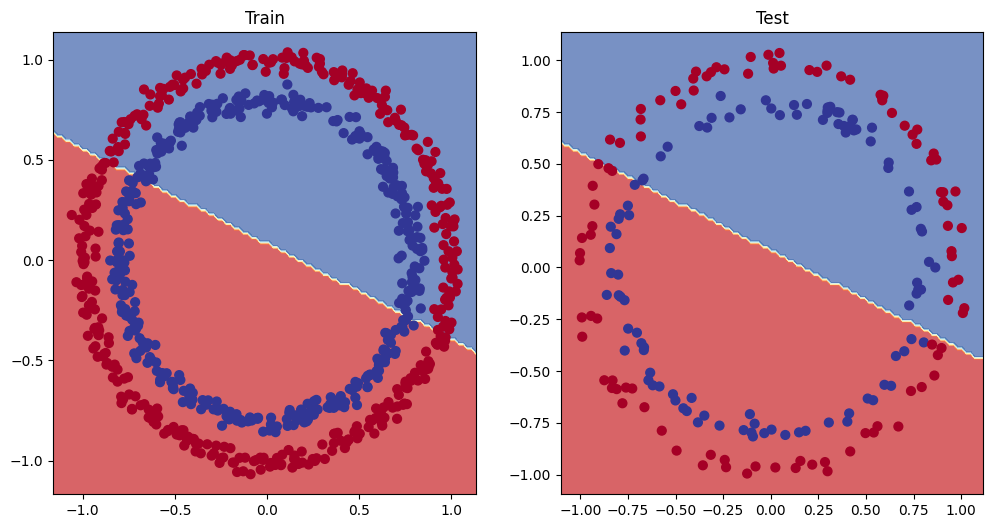

In [31]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

# Train
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

# Test
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers -> More "chances" to learn the patterns.
* Add more hidden units -> Going from 5 to 10 (for example)
* Fit for longer (more epochs)
* Changing activation functions 
* Changing the learning rate 
* Change loss function 

These are the **hyperparameters**.

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__() # It's the best way to "__init__" the father class nn.Module (in this case)
        self.layer1 = nn.Linear(in_features=2,
                                out_features=10) # * MORE HIDDEN UNITS ADDED *
        self.layer2 = nn.Linear(in_features=10, # * Must match the last out_features * 
                                out_features=10)
        self.layer3 = nn.Linear(in_features=10,
                                out_features=1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer3(self.layer2(self.layer1(x))) # This way of chaining functions works better than separate
    
model_1 = CircleModelV1()
model_1 

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Create loss 
loss_fn = nn.BCEWithLogitsLoss()

# Create optimizer 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [34]:
X_train.shape

torch.Size([800, 2])

In [35]:
# Write training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1.to(device)
epochs = 1000

for epoch in range(epochs):
    # 0. Train mode
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train)
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss & accuracy
    train_loss = loss_fn(y_logits,
                         y_train)
    train_acc = accuracy_fn(y_true=y_train,
                            y_pred=y_preds)
    
    # 3. Zero grad
    optimizer.zero_grad()
    
    # 4. Backpropagation 
    train_loss.backward()
    
    # 5. Gradient descent 
    optimizer.step()    

    # Tracking 
    if epoch % 25 == 0:
        with torch.inference_mode():
            model_1.eval()
            
            # 1. Pred 
            test_logits = model_1(X_test)
            test_preds = torch.round(torch.sigmoid(test_logits))
            
            # 2. Loss & accuracy
            test_loss = loss_fn(test_logits, y_test)
            
            print(f"Epoch: {epoch} | Loss: {train_loss:.5f} | Acc: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

            

Epoch: 0 | Loss: 0.69396 | Acc: 50.88 | Test loss: 0.69261 | Test acc: 47.00
Epoch: 25 | Loss: 0.69344 | Acc: 50.25 | Test loss: 0.69290 | Test acc: 47.00
Epoch: 50 | Loss: 0.69322 | Acc: 49.88 | Test loss: 0.69324 | Test acc: 47.00
Epoch: 75 | Loss: 0.69311 | Acc: 50.00 | Test loss: 0.69354 | Test acc: 47.00
Epoch: 100 | Loss: 0.69305 | Acc: 50.38 | Test loss: 0.69379 | Test acc: 47.00
Epoch: 125 | Loss: 0.69302 | Acc: 50.75 | Test loss: 0.69399 | Test acc: 47.00
Epoch: 150 | Loss: 0.69300 | Acc: 51.00 | Test loss: 0.69415 | Test acc: 47.00
Epoch: 175 | Loss: 0.69299 | Acc: 51.38 | Test loss: 0.69428 | Test acc: 47.00
Epoch: 200 | Loss: 0.69299 | Acc: 51.12 | Test loss: 0.69437 | Test acc: 47.00
Epoch: 225 | Loss: 0.69298 | Acc: 51.25 | Test loss: 0.69445 | Test acc: 47.00
Epoch: 250 | Loss: 0.69298 | Acc: 51.62 | Test loss: 0.69450 | Test acc: 47.00
Epoch: 275 | Loss: 0.69298 | Acc: 51.50 | Test loss: 0.69454 | Test acc: 47.00
Epoch: 300 | Loss: 0.69298 | Acc: 51.62 | Test loss: 0.69

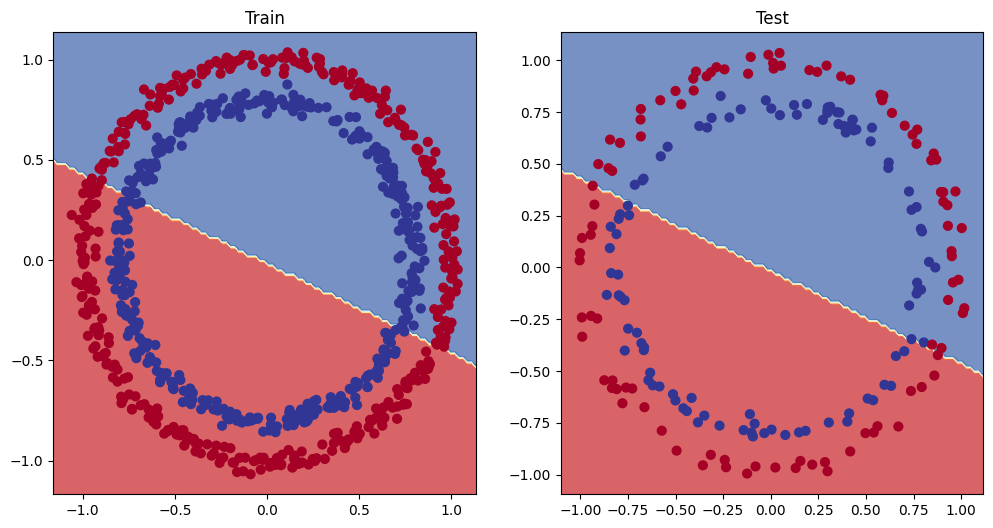

In [36]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

# Train
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

# Test
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line 

In [37]:
# Create some data 
weight = 0.7
bias = 0.3 
start = 0
end = 1
step = 0.01

X_regresion = torch.arange(start, end, step).unsqueeze(dim=1)
y_regresion = weight * X_regresion + bias

# Check the data
print(len(X_regresion))
X_regresion[:5], y_regresion[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [38]:
# Create train and test splits 
train_split = int(0.8 * len(X_regresion))
X_train_regresion, y_train_regresion = X_regresion[:train_split], y_regresion[:train_split]
X_test_regresion, y_test_regresion = X_regresion[train_split:], y_regresion[train_split:]
len(X_train_regresion), len(X_test_regresion)

(80, 20)

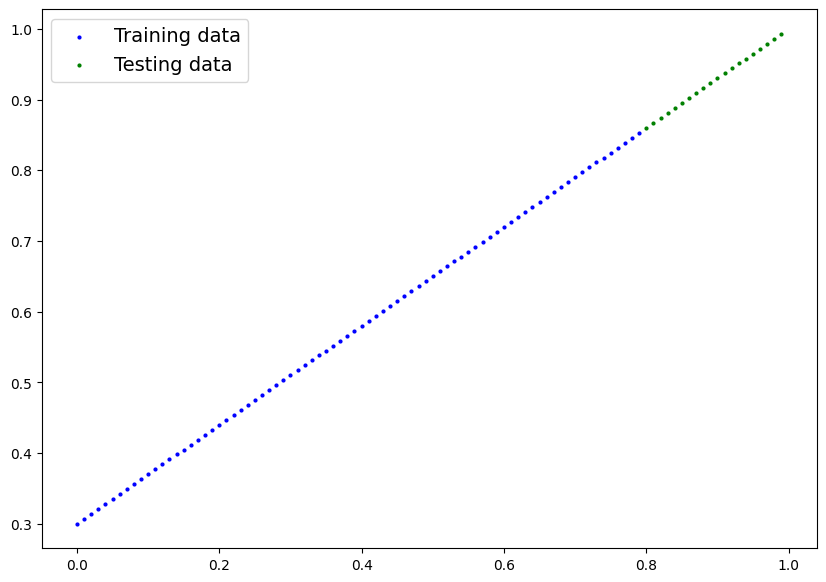

In [39]:
plot_predictions(train_data=X_train_regresion, train_labels=y_train_regresion,
                 test_data=X_test_regresion, test_labels=y_test_regresion)

### 5.2 Adjusting `model_1` to fit straight line 

In [40]:
# Same architecture as model_1 
model_2 = nn.Sequential(
    nn.Linear(in_features=1,
              out_features=10),
    nn.Linear(in_features=10,
              out_features=10),
    nn.Linear(in_features=10,
              out_features=1)
).to(device)

In [41]:

# Loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)
# Data to device
X_train_regresion = X_train_regresion.to(device)
X_test_regresion = X_test_regresion.to(device) 
y_train_regresion = y_train_regresion.to(device) 
y_test_regresion = y_test_regresion.to(device)


In [42]:
# Train
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
for epoch in range(epochs):
    # 0. Train 
    model_2.train()
    
    # 1. Forward pass
    y_pred = model_2(X_train_regresion)
    
    # 2. Loss
    loss = loss_fn(y_pred,
                   y_train_regresion)
    
    # 3. Zero grad
    optimizer.zero_grad()
    
    # 4. Backpropagation
    loss.backward()
    
    # 5. Gradient descent 
    optimizer.step()
    
    # Tracking 
    if epoch % 100 == 0:
        with torch.inference_mode():
            model_2.eval()
            test_pred = model_2(X_test_regresion)
            test_loss = loss_fn(test_pred,
                                y_test_regresion)
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
            

Epoch: 0 | Loss: 0.7598584890365601 | Test loss: 0.541427731513977
Epoch: 100 | Loss: 0.09308688342571259 | Test loss: 0.029011651873588562
Epoch: 200 | Loss: 0.07375651597976685 | Test loss: 0.028500307351350784
Epoch: 300 | Loss: 0.067450612783432 | Test loss: 0.006151741836220026
Epoch: 400 | Loss: 0.06106739118695259 | Test loss: 0.020039543509483337
Epoch: 500 | Loss: 0.056982576847076416 | Test loss: 0.010608002543449402
Epoch: 600 | Loss: 0.048567451536655426 | Test loss: 0.013261097483336926
Epoch: 700 | Loss: 0.06108738109469414 | Test loss: 0.02126910164952278
Epoch: 800 | Loss: 0.055995307862758636 | Test loss: 0.014254355803132057
Epoch: 900 | Loss: 0.05571334436535835 | Test loss: 0.006033414509147406


In [43]:
X_train_regresion.shape, y_train_regresion.shape, X_test_regresion.shape, y_test_regresion.shape, y_pred.shape

(torch.Size([80, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([20, 1]),
 torch.Size([80, 1]))

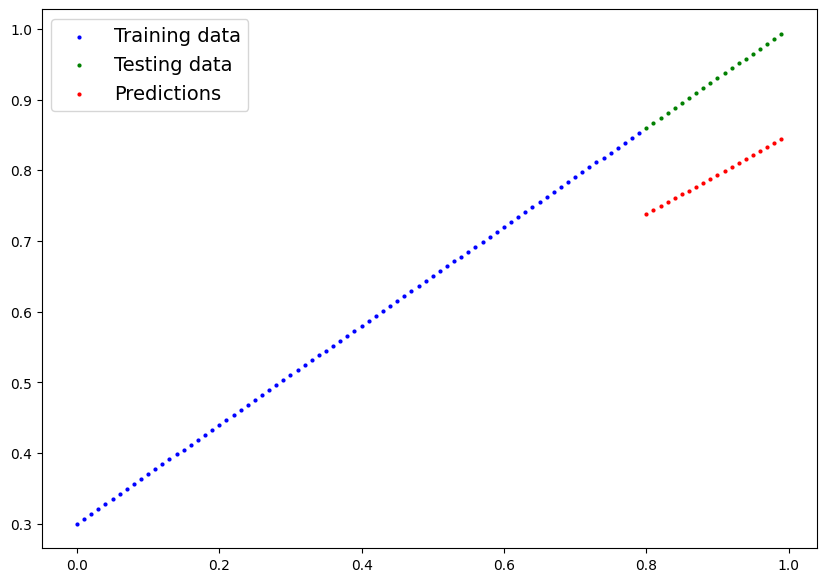

In [44]:
# Plot predictions 
with torch.inference_mode():
    model_2.eval()
    y_pred = model_2(X_test_regresion)
plot_predictions(train_data=X_train_regresion.to("cpu"), train_labels=y_train_regresion.to("cpu"),
                 test_data=X_test_regresion.to("cpu"), test_labels=y_test_regresion.to("cpu"),
                 predictions=y_pred.to("cpu"))

## 6. The missing piece: the non-lineariy   

"What patterns could you draw if you were given an infinite amount of straight lines and non-straight lines?"


### 6.1 Reacreating non-linearity data (red and blue circles)

(not necesary but just for practice)

In [45]:
# Make and plot data
n_samples = 1000
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)


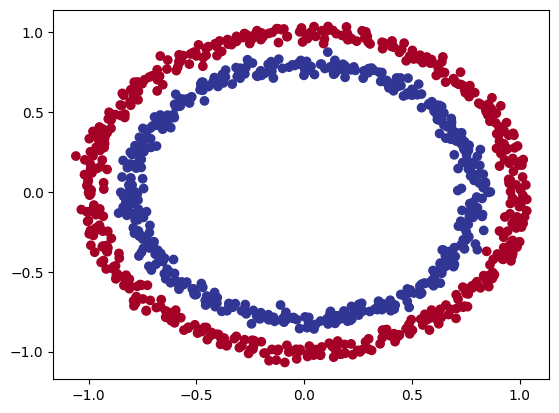

In [46]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y,
            cmap=plt.cm.RdYlBu) 
plt.show()

In [47]:
# Convert data to tensors 
X, y = torch.from_numpy(X), torch.from_numpy(y)

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42) 

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], dtype=torch.float64),
 tensor([1, 0, 0, 0, 1]))

### 6.2 Building a model with non-linearity 

In [124]:
# Build model with non-linearity functions
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Linear layers
        self.layer1 = nn.Linear(in_features=2,
                                out_features=20)
        self.layer2 = nn.Linear(in_features=20,
                                out_features=20)
        self.layer3 = nn.Linear(in_features=20,
                                out_features=1)
        
        # Non-linear function
        self.relu = nn.ReLU()
        
    # Forward method 
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        return self.layer3(self.relu(self.layer2(self.layer1(X))))
        
model_3 = CircleModelV2().to(device)
model_3, next(model_3.parameters()).device

(CircleModelV2(
   (layer1): Linear(in_features=2, out_features=20, bias=True)
   (layer2): Linear(in_features=20, out_features=20, bias=True)
   (layer3): Linear(in_features=20, out_features=1, bias=True)
   (relu): ReLU()
 ),
 device(type='cpu'))

In [125]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

# Send data to GPU
X_train = X_train.to(device).type(dtype=torch.float)
X_test = X_test.to(device).type(dtype=torch.float)
y_train = y_train.to(device).type(dtype=torch.float)
y_test = y_test.to(device).type(dtype=torch.float)
X_train.device

device(type='cpu')

In [126]:
# Matrix for if needed
if y_train.dim() == 1:
    print("Unsqueezed!")
    y_train = y_train.unsqueeze(dim=1)
    y_test = y_test.unsqueeze(dim=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800, 1]),
 torch.Size([200, 1]))

In [127]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1500  

for epoch in range(epochs):
    model_3.train()
    
    # Preds
    y_logits = model_3(X_train)
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # Loss
    loss = loss_fn(y_logits, # Rembember we're using BCEWIthLogits 
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # Zero grad, backpropagation, gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Tracking 
    if epoch % 100 == 0:
        with torch.inference_mode():
            model_3.eval()
            test_logits = model_3(X_test)
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            print(f"Epoch: {epoch} | Loss & acc: [{loss:.5f}, {acc:.2f}] | Test loss & acc: [{test_loss:.5f}, {test_acc:.2f}]")
    

Epoch: 0 | Loss & acc: [0.69568, 46.88] | Test loss & acc: [0.00603, 52.00]
Epoch: 100 | Loss & acc: [0.68951, 68.12] | Test loss & acc: [0.00603, 66.50]
Epoch: 200 | Loss & acc: [0.68433, 71.25] | Test loss & acc: [0.00603, 65.50]
Epoch: 300 | Loss & acc: [0.67736, 73.25] | Test loss & acc: [0.00603, 67.50]
Epoch: 400 | Loss & acc: [0.66623, 77.25] | Test loss & acc: [0.00603, 72.00]
Epoch: 500 | Loss & acc: [0.64829, 79.75] | Test loss & acc: [0.00603, 72.00]
Epoch: 600 | Loss & acc: [0.61826, 87.25] | Test loss & acc: [0.00603, 81.50]
Epoch: 700 | Loss & acc: [0.56989, 94.88] | Test loss & acc: [0.00603, 91.50]
Epoch: 800 | Loss & acc: [0.49484, 97.62] | Test loss & acc: [0.00603, 94.00]
Epoch: 900 | Loss & acc: [0.39125, 99.25] | Test loss & acc: [0.00603, 98.00]
Epoch: 1000 | Loss & acc: [0.27787, 99.62] | Test loss & acc: [0.00603, 98.50]
Epoch: 1100 | Loss & acc: [0.18543, 100.00] | Test loss & acc: [0.00603, 100.00]
Epoch: 1200 | Loss & acc: [0.12545, 100.00] | Test loss & acc:

## 6.4 Evaluating the model trained with non-linear activaton functions 

In [128]:
def pred_from_logits_sigmoid(y_logits: torch.Tensor) -> torch.Tensor:
    return torch.round(torch.sigmoid(y_logits))

In [129]:
# Make predictions 
with torch.inference_mode():
    model_3.eval()
    y_logits = model_3(X_test)
    y_pred = pred_from_logits_sigmoid(y_logits)
y_pred[:5], y_test[:5]

(tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]]))

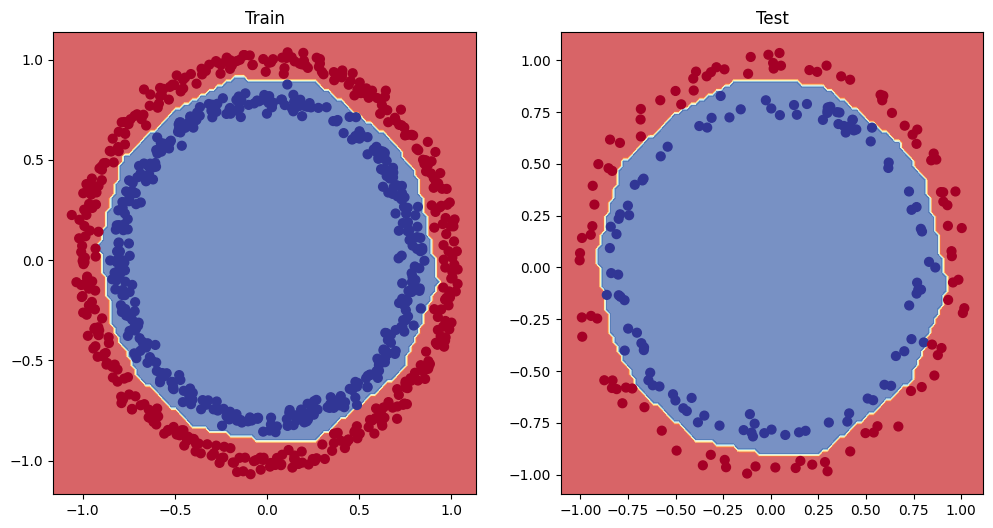

In [130]:
# Plot decision boundaries 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


**Challenge** Can you improve the 80% accuracy on the test data?

* Did it, just increased inner dimensions of the nn from 10 to 20 and trained for another 500 epochs.

## 7. Replicating non-linear functions  

### 7.1 Relu

In [132]:
# Create a tensor 
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

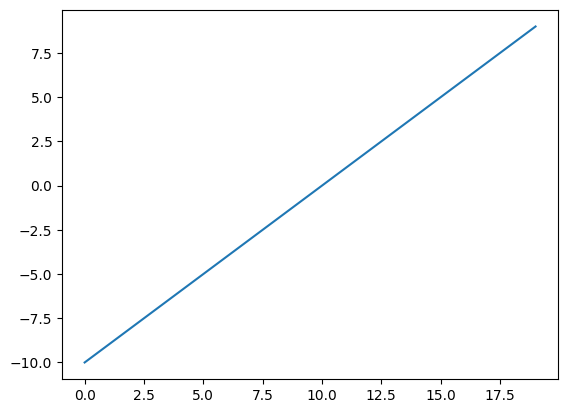

In [134]:
# Visualize tensor 
plt.plot(A)
plt.show()

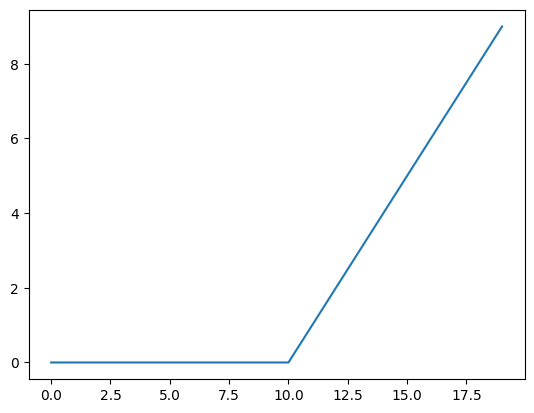

In [136]:
plt.plot(torch.relu(A))
plt.show()

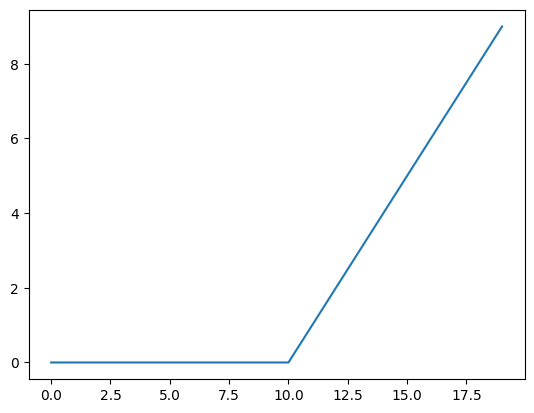

In [ ]:
# Hand-made relu
def relu(x:torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0),x) # Inputs must be tensors

# Plot 
plt.plot(relu(A))
plt.show()

### 7.2 Sigmoid 

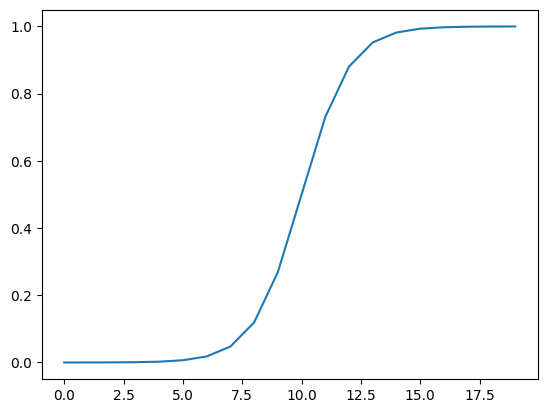

In [139]:
def sigmoid(x:torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

# Plot
plt.plot(sigmoid(A))
plt.show()